# Neural Network

**Typical Training Procedure for A Neural Network**  
1. define the neural network that has some learnable parameters (or weights)
2. iterate over a dataset of inputs
3. process input through the network
4. compute the loss (how far is the output from being correct)
5. propagare the gradients back into the network's parameters
6. updates the weights of the network, typically using a simple update rule:
$$weight = weight - learning_rate * gradient$$

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5 x 5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = wx + b
        self.fc1 = nn.Linear(16*5 * 5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self, input): # Note: expected input size is 32 x 32
        # convolution layer C1: input 1 input image channel, 6 output channels
        # kernel size 5x5
        # use ReLU as activation function
        # outputs a Tensor with (N, 6, 28, 28)
        c1 = F.relu(self.conv1(input))
        # subsampling layer S2: 2x2 grid
        s2 = F.max_pool2d(c1, (2,2))
        # convolution layer C3: 6 input channels, 16 output channels, 5x5 kernel
        c3 = F.relu(self.conv2(s2))
        # subsampling layer s4: 2x2 grid
        s4 = F.max_pool2d(c3, (2,2))
        # flatten operation
        s4 = torch.flatten(s4,1)
        # fully connected layer F5: 16*5*5 inputs, 120 outputs
        f5 = F.relu(self.fc1(s4))
        # fully connected layer F6: 120 inputs, 84 outputs
        f6 = F.relu(self.fc2(f5))
        # fully connected layer F7: 84 inputs, 10 outputs
        output = self.fc3(f6)
        return output

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [7]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 5, 5])


In [ ]:
# try a random 32 x 32 input
input = torch.randn(1,1,32,32)
output = net(input)
print(output)
# backward pass
net.zero_grad()
output.backward(torch.randn(1,10)) # simulate a loss to backpropagate

tensor([[ 0.0012, -0.0273,  0.0123,  0.1208,  0.1903, -0.0188,  0.0795,  0.1289,
          0.0931, -0.0772]], grad_fn=<AddmmBackward0>)


## Loss Function

A loss function takes the (output, target) pair of inputs, and computes a value that estimate how far away the output is from the target.  
There are several different loss functions under the ```nn``` package. A simple loss function is ```nn.MSELoss``` which computes the mean squared error between the output and the target.

In [15]:
output = net(input)
target = torch.randn(10)
print(target)
target = target.view(1,-1) # make it the same shape as output
print(target)
criterion = nn.MSELoss()
loss = criterion(output, target)
print(loss)

tensor([ 0.4107,  1.1274, -1.4355,  1.5497, -0.2493,  1.2496, -0.2662,  0.8032,
         0.3911,  1.1562])
tensor([[ 0.4107,  1.1274, -1.4355,  1.5497, -0.2493,  1.2496, -0.2662,  0.8032,
          0.3911,  1.1562]])
tensor(0.9625, grad_fn=<MseLossBackward0>)


In [16]:
# manually backpropagate example
print(loss.grad_fn) #MSELoss
print(loss.grad_fn.next_functions[0][0]) #Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0]) #ReLU

In [18]:
## Auto Backpropagate
net.zero_grad()
print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)
loss.backward()
print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([ 0.0077,  0.0084,  0.0055,  0.0051, -0.0003,  0.0025])


## Update the weights

$weight = weight - learning\space rate \times gradient$

In [21]:
## manually update the weights
learning_rate = 0.01
for param in net.parameters():
    param.data.sub_(learning_rate * param.grad.data)


In [24]:
## automatically update the weights by more approaches
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr = 0.01)

optimizer.zero_grad()
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step() # update the weights

# Trainig a classifier

In A 60 minute Blitz, we will use the CIFAR10 dataset. It has classes: "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship" and "truck". The images in CIFAR-10 are of size 3 x 32 x 32 (3 channel color images of 32 x 32 pixels in size.

Steps to training an image classifer
1. load and normalise the CIFAR-10 training and test datasets using torchvision
2. define a convolutional neural network
3. define a loss function
4. train the network on the training data
5. test the network on the test data

In [82]:
# load and normalise the CIFAR-10
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root = "./data", train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 2)
testset = torchvision.datasets.CIFAR10(root = "./data", train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [34]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------------------------- -------------- 5.2/8.1 MB 25.8 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 24.0 MB/s  0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 20.3 MB/s  0:00:00

   ---------------------------------------- 0/6 [pyparsing]
   ---------------------------------------- 0/6 [pyparsing]
   ------ --------------------------------- 1/6 [kiwisolver]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- 

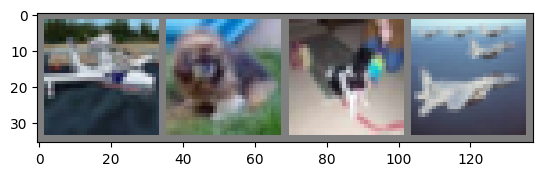

plane dog   dog   plane


In [83]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Define a convolutional neural network

In [95]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x =self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

### Define a loss function and optimiser

In [96]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9) # momentum = 0.9
# updates keep moving strongly in the same direction as before, unless the new gradient really disagrees

### Train the Network

In [97]:
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f"[{epoch + 1}, {i + 1 :5d}] loss: {running_loss/2000:.3f}")
            running_loss = 0.00
print("Finished Training")

[1,  2000] loss: 2.172
[1,  4000] loss: 1.825
[1,  6000] loss: 1.648
[1,  8000] loss: 1.590
[1, 10000] loss: 1.516
[1, 12000] loss: 1.449
[2,  2000] loss: 1.364
[2,  4000] loss: 1.364
[2,  6000] loss: 1.339
[2,  8000] loss: 1.292
[2, 10000] loss: 1.275
[2, 12000] loss: 1.255
[3,  2000] loss: 1.183
[3,  4000] loss: 1.181
[3,  6000] loss: 1.181
[3,  8000] loss: 1.153
[3, 10000] loss: 1.165
[3, 12000] loss: 1.134
[4,  2000] loss: 1.080
[4,  4000] loss: 1.080
[4,  6000] loss: 1.082
[4,  8000] loss: 1.074
[4, 10000] loss: 1.068
[4, 12000] loss: 1.079
[5,  2000] loss: 0.995
[5,  4000] loss: 1.012
[5,  6000] loss: 1.010
[5,  8000] loss: 0.983
[5, 10000] loss: 1.030
[5, 12000] loss: 1.019
Finished Training


### Test the model on test data

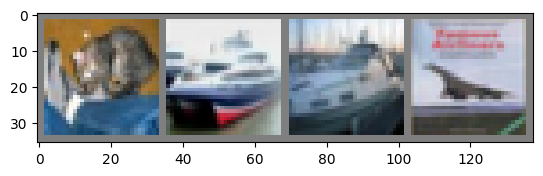

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter) # take the first batch of test images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

### Save the model

In [50]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Reload the model if necessary

In [56]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only = True))

<All keys matched successfully>

In [ ]:
## see how the network performs on the images we selected
outputs = net(images)
_, predicted = torch.max(outputs, 1) # 1 means find the max value across the 10 prediction scores
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  dog   ship  car   plane


In [98]:
## check accuracy of the whole dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct//total} %")

Accuracy of the network on the 10000 test images: 63 %


In [62]:
# check accuracy for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count)/total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")

Accuracy for class: plane is 76.8 %
Accuracy for class: car   is 77.8 %
Accuracy for class: bird  is 55.3 %
Accuracy for class: cat   is 29.5 %
Accuracy for class: deer  is 39.3 %
Accuracy for class: dog   is 43.9 %
Accuracy for class: frog  is 76.2 %
Accuracy for class: horse is 69.9 %
Accuracy for class: ship  is 76.0 %
Accuracy for class: truck is 51.7 %


### Hyperparameter Tuning

#### Learning Rate

If we do grid search, it is very time-consuming. Hence, it is better to focus on a narrower range and then we apply grid/random search. To do so, we can conduct learning rate range test first to see how the loss changes with the change of learning rate.

In [104]:
# initialise the network
net = Net()
# define optimiser
lr_start = 1e-5
lr_end = 0.01
num_iters = len(trainloader)
optimizer = optim.SGD(net.parameters(), lr = lr_start, momentum = 0.9)
lrs = np.logspace(np.log10(lr_start), np.log10(lr_end), num_iters)

In [105]:
# lr range test
losses = []
for i, (inputs, labels) in enumerate(trainloader):
    lr = lrs[i]
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    

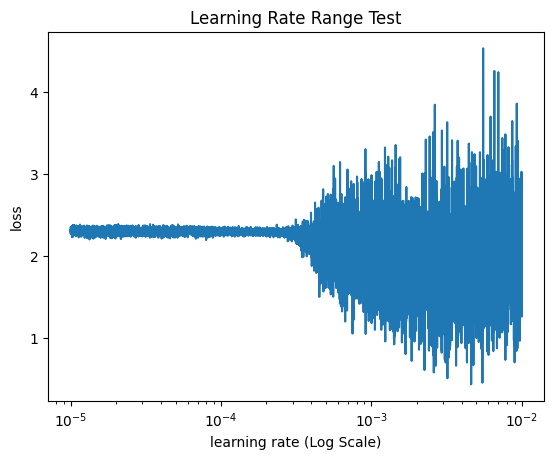

In [106]:
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('learning rate (Log Scale)')
plt.ylabel('loss')
plt.title("Learning Rate Range Test")
plt.show()

In [110]:
net = Net() # important! initialise the network
optimizer = optim.SGD(net.parameters(), lr = 0.0005, momentum = 0.9)
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f"[{epoch + 1}, {i + 1 :5d}] loss: {running_loss/2000:.3f}")
            running_loss = 0.00
print("Finished Training")

[1,  2000] loss: 2.301
[1,  4000] loss: 2.163
[1,  6000] loss: 1.876
[1,  8000] loss: 1.742
[1, 10000] loss: 1.647
[1, 12000] loss: 1.577
[2,  2000] loss: 1.513
[2,  4000] loss: 1.482
[2,  6000] loss: 1.425
[2,  8000] loss: 1.403
[2, 10000] loss: 1.405
[2, 12000] loss: 1.381
[3,  2000] loss: 1.294
[3,  4000] loss: 1.281
[3,  6000] loss: 1.273
[3,  8000] loss: 1.275
[3, 10000] loss: 1.263
[3, 12000] loss: 1.224
[4,  2000] loss: 1.173
[4,  4000] loss: 1.181
[4,  6000] loss: 1.160
[4,  8000] loss: 1.159
[4, 10000] loss: 1.148
[4, 12000] loss: 1.149
[5,  2000] loss: 1.082
[5,  4000] loss: 1.068
[5,  6000] loss: 1.102
[5,  8000] loss: 1.082
[5, 10000] loss: 1.082
[5, 12000] loss: 1.094
Finished Training


In [111]:
## check accuracy of the whole test dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct//total} %")

Accuracy of the network on the 10000 test images: 61 %


In [112]:
# check accuracy for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count)/total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")

Accuracy for class: plane is 63.6 %
Accuracy for class: car   is 69.5 %
Accuracy for class: bird  is 61.9 %
Accuracy for class: cat   is 33.3 %
Accuracy for class: deer  is 54.1 %
Accuracy for class: dog   is 41.0 %
Accuracy for class: frog  is 60.9 %
Accuracy for class: horse is 71.7 %
Accuracy for class: ship  is 79.7 %
Accuracy for class: truck is 77.0 %
